In [2]:
cd /home/cougarnet.uh.edu/pyuan2/Projects/DeepLung-3D_Lung_Nodule_Detection

/home/cougarnet.uh.edu/pyuan2/Projects/DeepLung-3D_Lung_Nodule_Detection


In [3]:
from argparse import ArgumentParser
from prepare import lumTrans
from show_results import add_bbox
from statistics import mode
from skimage.filters import threshold_otsu
from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [61]:
def load_mhd(data_path, label_path=None, load_label=False):
    '''
    param:
        data_path: endswith .mhd
    return:
         sliceim: npArray, shape == (slices, height, weight)
         label: npArray, shape == (n, 4) -> (z, y, x, d)
    '''
    from prepare import load_itk_image, resample, worldToVoxelCoord
    sliceim, origin, spacing, isflip = load_itk_image(data_path)
    print("Spaing is: ", spacing)
    ori_shape = sliceim.shape
    if isflip:
        sliceim = sliceim[:, ::-1, ::-1]
    resolution = np.array([1, 1, 1])
    sliceim, _ = resample(sliceim, spacing, resolution, order=1)
    filename = data_path.split("/")[-1].rstrip(".mhd")
    label = []
    if load_label:
        annos = np.array(pd.read_csv(label_path))
        this_annos = np.copy(annos[annos[:, 0] == (filename)])
        for c in this_annos:
            pos = worldToVoxelCoord(c[1:4][::-1], origin=origin, spacing=spacing)
            if isflip:
                pos[1:] = ori_shape[1:3] - pos[1:]
            label.append(np.concatenate([pos, [c[4] / spacing[1]]]))
        label = np.array(label).T
        if len(label) > 0:
            label[:3] = label[:3] * np.expand_dims(spacing, 1) / np.expand_dims(resolution, 1)
            label[3] = label[3] * spacing[1] / resolution[1]
            # label[:3] = label[:3] - np.expand_dims(extendbox[:, 0], 1)
            label = label[:4].T
    label = np.array(label)

    return sliceim, label

def load_npy(data_path, label_path=None, load_label=False):
    '''
    param:
        data_path: endswith .npy
    return:
         sliceim: npArray, shape == (slices, height, weight)
         label: npArray, shape == (n, 4) -> (z, y, x, d)
    '''
    sliceim = np.load(data_path, allow_pickle=True)
    if len(sliceim) == 1 and len(sliceim.shape) == 4:
        sliceim = sliceim[0]
    dirpath = os.path.dirname(data_path)
    filename = data_path.split("/")[-1].rstrip("_clean.npy")
    label = []
    if load_label:
        assert label_path is None
        if label_path is None:
            label = np.load(os.path.join(dirpath, filename + '_label.npy'), allow_pickle=True)
            if np.all(label == 0):
                label = []
    label = np.array(label)
    return sliceim, label

def load_npz(data_path, label_path=None, load_label=False):
    '''
    param:
        data_path: endswith .npy
    return:
         sliceim: npArray, shape == (slices, height, weight)
         label: npArray, shape == (n, 4) -> (z, y, x, d)
    '''
    sliceim = np.load(data_path, allow_pickle=True)["image"]
    if len(sliceim) == 1 and len(sliceim.shape) == 4:
        sliceim = sliceim[0]

    dirpath = os.path.dirname(data_path)
    filename = data_path.split("/")[-1].rstrip("_clean.npz")
    label = []
    if load_label:
        if label_path is None:
            label = np.load(os.path.join(dirpath, filename + '_label.npz'), allow_pickle=True)["label"]
            if np.all(label == 0):
                label = []
        else:
            pos_df = pd.read_csv(label_path)
            pstr, dstr = filename.split("-")
            patient_colname = "patient" if "patient" in pos_df.columns else 'Patient\n Index'
            assert patient_colname in pos_df
            existId = (pos_df[patient_colname] == pstr) & (pos_df["date"] == int(dstr))
            label = pos_df[existId][["z", "y", "x", "d"]].values
    label = np.array(label)
    return sliceim, label

In [50]:
def plot_data(data_path, label_path, nodule_index, Slice, norm):

    load_label = True if nodule_index != -1 else False

    ## load image
    if data_path.endswith(".mhd"):
        scan, label = load_mhd(data_path, label_path, load_label)
    elif data_path.endswith(".npy"):
        scan, label = load_npy(data_path, label_path, load_label)
    else:
        assert data_path.endswith(".npz")
        scan, label = load_npz(data_path, label_path, load_label)
    print("Load data: ", data_path)
    print("Image shape: ", scan.shape)

    ## intensity normalization
    if norm == "min_max":
        scan = lumTrans(scan)
    elif norm == "mode_norm":
        # t = threshold_otsu(image)
        t = -400
        m = mode(scan[scan < t])
        std = np.std(scan[scan < t])
        scan = (scan - m) / std

    t = threshold_otsu(scan)
    scan_copy = np.copy(scan.reshape(-1))
    bg = mode(scan_copy)
    scan_copy = scan_copy[scan_copy != bg]
    m = mode(scan_copy[scan_copy < t])
    std = np.std(scan_copy[scan_copy < t])
    print("Fisrt: Mode: {:f}, std: {:f}".format(m, std))
    m = mode(scan_copy[scan_copy > t])
    std = np.std(scan_copy[scan_copy > t])
    print("Second: Mode: {:f}, std: {:f}".format(m, std))
        
    ## load label
    if load_label and nodule_index < len(label):
        z = int(label[nodule_index][0])
        l = label[nodule_index]
        print("All labels: ", label)
    elif Slice:
        z = Slice
        l = None
    else:
        z = np.random.randint(0, scan.shape[0])
        l = None

    ## plot data
    fig, axes = plt.subplots(1, 4, figsize=(6.4 * 4, 4.8))
    if l is not None:
        im = add_bbox(axes[0], scan, None, l)
    else:
        im = axes[0].imshow(scan[z], cmap="gray")
    axes[0].set_title("slice {:d}".format(z))
    axes[1].hist(scan.reshape(-1), bins=100)
    axes[1].set_title("histogram")
    fig.colorbar(mappable=im, ax=axes[0])


   ## plot hist
    scan_reshape = scan.reshape(-1)
    bg = mode(scan_reshape)
    scan_reshape = scan_reshape[scan_reshape != bg]
    print("Remove background", bg)
    t = threshold_otsu(scan_reshape)
    first_stack = scan_reshape[scan_reshape < t]
    second_stack = scan_reshape[scan_reshape > t]
    bins1 = min([100, len(set(first_stack))])
    bins2 = min([100, len(set(second_stack))])

    axes[2].hist(first_stack, bins=bins1)
    axes[2].set_title("histogram first stack")
    axes[3].hist(second_stack, bins=bins2)
    axes[3].set_title("histogram second stack")

    plt.show()

In [ ]:
def 

In [63]:
def check_statistic(root_dir, label_path=None, norm=None):
    
    path = os.walk(root_dir)
    load_label = False
    
    mode1_ls, mode2_ls = [], []
    std1_ls, std2_ls = [], []

    for root, directories, files in path:
        for file in files:
            if file.endswith("_clean.npz") or file.endswith("_clean.npy") or file.endswith(".mhd"):
                data_path = os.path.join(root, file)
                print(data_path)
                
                ## load image
                if data_path.endswith(".mhd"):
                    scan, label = load_mhd(data_path, label_path, load_label)
                elif data_path.endswith(".npy"):
                    scan, label = load_npy(data_path, label_path, load_label)
                else:
                    assert data_path.endswith(".npz")
                    scan, label = load_npz(data_path, label_path, load_label)

                ## intensity normalization
                if norm == "min_max":
                    scan = lumTrans(scan)
                elif norm == "mode_norm":
                    # t = threshold_otsu(image)
                    t = -400
                    m = mode(scan[scan < t])
                    std = np.std(scan[scan < t])
                    scan = (scan - m) / std

                scan = scan.reshape(-1)
                bg = mode(scan)
                scan = scan[scan != bg]
                print("Remove background", bg)
                t = -400
                m = mode(scan[scan < t])
                std = np.std(scan[np.logical_and(scan > m - 200, scan < m + 200)])
#                 std = np.std(scan[scan < t])
                mode1_ls.append(m)
                std1_ls.append(std)
                print("Fisrt: Mode: {:f}, std: {:f}".format(m, std))
                m = mode(scan[scan > t])
                std = np.std(scan[np.logical_and(scan > m - 200, scan < m + 200)])
#                 std = np.std(scan[scan > t])
                mode2_ls.append(m)
                std2_ls.append(std)
                print("Second: Mode: {:f}, std: {:f}".format(m, std))
    
    fig, axes = plt.subplots(1, 4, figsize=(6.4 * 4, 4.8))
    axes[0].hist(mode1_ls, bins=100)
    axes[0].set_title("mode histogram first stack")
    axes[1].hist(std1_ls, bins=100)
    axes[1].set_title("std histogram second stack")
    axes[2].hist(mode2_ls, bins=100)
    axes[2].set_title("mode histogram first stack")
    axes[3].hist(std2_ls, bins=100)
    axes[3].set_title("std histogram second stack")
    plt.show()
    

## Compare raw images

Luna raw data
read itkimage successfully
Load data:  ./LUNA16/raw_files/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd
Image shape:  (302, 390, 390)
Remove background -3024


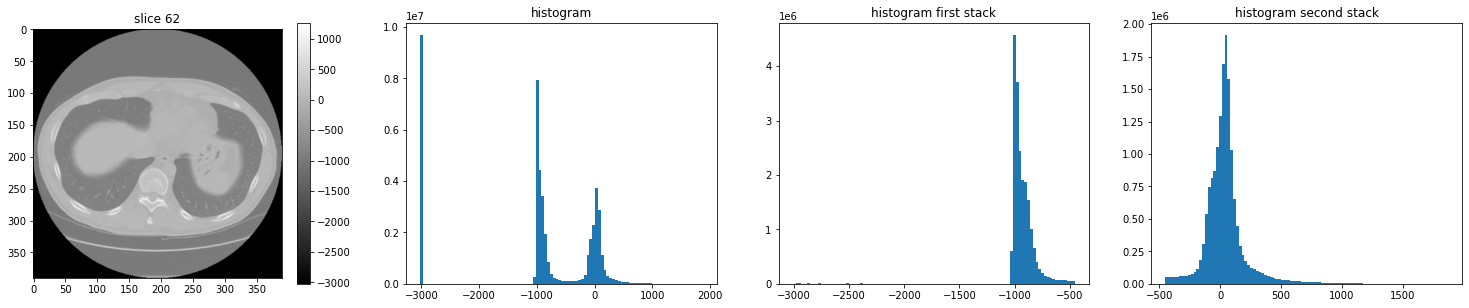

In [5]:
data_path = "./LUNA16/raw_files/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd"
label_path = None
nodule_index = -1
Slice = 62
norm = None
print("Luna raw data")
plot_data(data_path, label_path, nodule_index, Slice, norm)

Luna raw data2
read itkimage successfully
Load data:  ./LUNA16/raw_files/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd
Image shape:  (298, 380, 380)
All labels:  [[81.933381 257.26051683000003 81.9320555 6.440878725]]
Remove background -2048


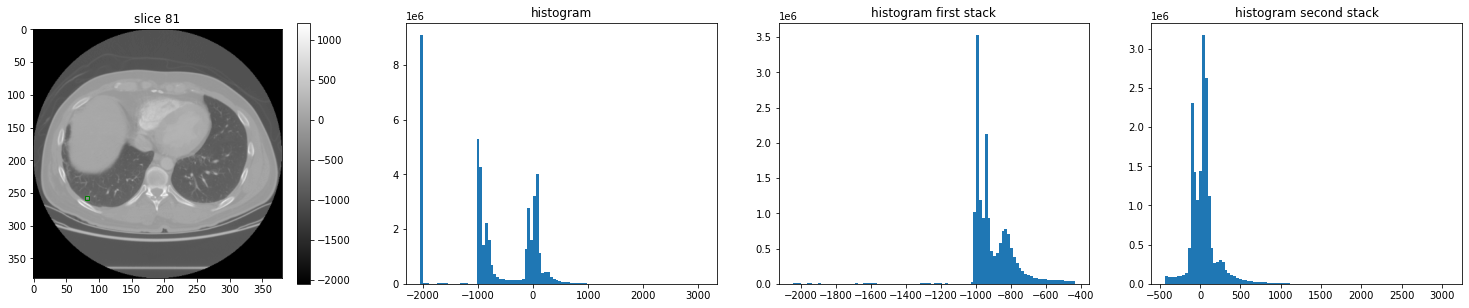

In [6]:
data_path = "./LUNA16/raw_files/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd"
label_path = "./LUNA16/annotations.csv"
nodule_index = 0
Slice = None
norm = None
print("Luna raw data2")
plot_data(data_path, label_path, nodule_index, Slice, norm)

Methodist raw data
Load data:  ./Methodist_incidental/data_Ben/resampled/Lung_patient002/patient002-20090310.npz
Image shape:  (290, 411, 411)
All labels:  [[132.        266.        254.         24.0704501]]
Remove background -1024


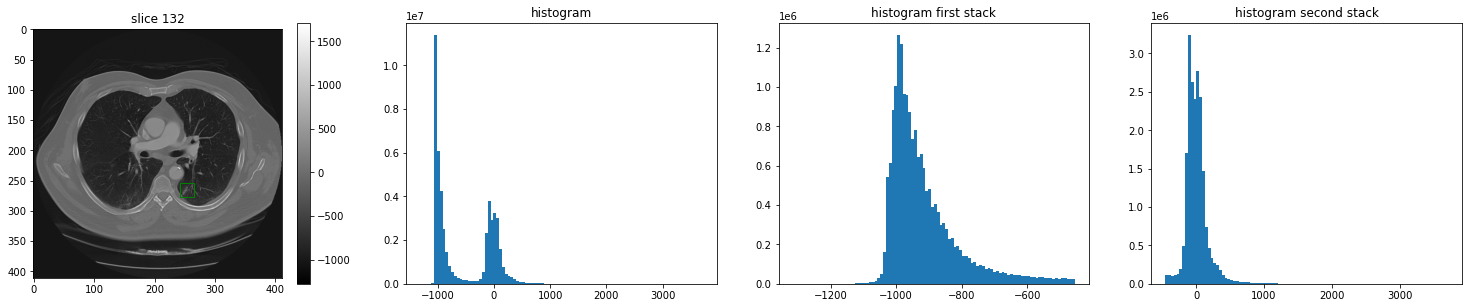

In [7]:
data_path = "./Methodist_incidental/data_Ben/resampled/Lung_patient002/patient002-20090310.npz"
label_path = "./Methodist_incidental/data_Ben/resampled/pos_labels_norm.csv"
nodule_index = 0
Slice = None
norm = None
print("Methodist raw data")
plot_data(data_path, label_path, nodule_index, Slice, norm)

Methodist raw data2
Load data:  ./Methodist_incidental/data_Ben/resampled/Lung_patient050/patient050-20130820.npz
Image shape:  (315, 434, 434)
All labels:  [[ 61.         253.         301.          27.11545988]]
Remove background -1024


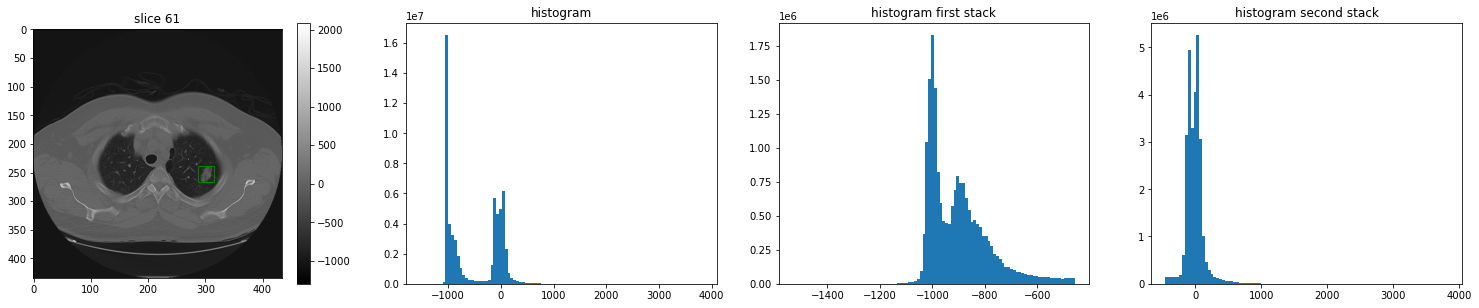

In [8]:
data_path = "./Methodist_incidental/data_Ben/resampled/Lung_patient050/patient050-20130820.npz"
label_path = "./Methodist_incidental/data_Ben/resampled/pos_labels_norm.csv"
nodule_index = 0
Slice = None
norm = None
print("Methodist raw data2")
plot_data(data_path, label_path, nodule_index, Slice, norm)

## Compare masked images (Min_max norm)

Luna masked data min_max norm
Load data:  ./LUNA16/masked_files/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492_clean.npy
Image shape:  (287, 191, 305)
All labels:  [[81.933381 166.26051683000003 43.932055500000004 6.440878725]]
Remove background 170


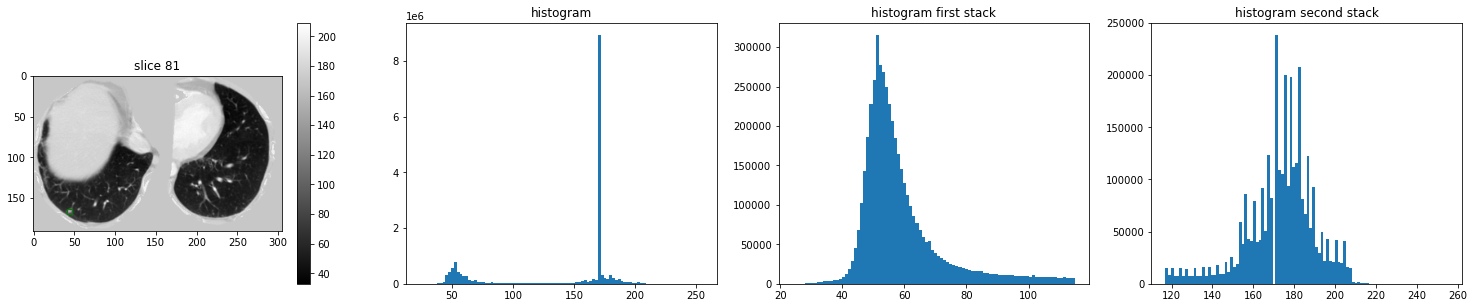

In [9]:
data_path = "./LUNA16/masked_files/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492_clean.npy"
label_path = None
nodule_index = 0
Slice = None
norm = "min_max"
print("Luna masked data min_max norm")
plot_data(data_path, label_path, nodule_index, Slice, norm)

Methodist masked data min_max norm
Load data:  ./Methodist_incidental/data_Ben/masked/Lung_patient002/patient002-20090310_clean.npz
Image shape:  (285, 255, 343)
All labels:  [[127.        189.        215.         24.0704501]]
Remove background 170


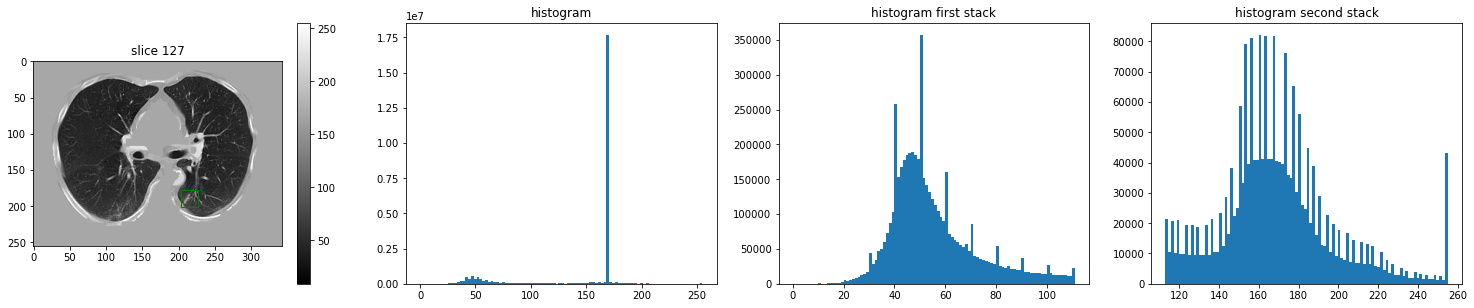

In [10]:
data_path = "./Methodist_incidental/data_Ben/masked/Lung_patient002/patient002-20090310_clean.npz"
label_path = None
nodule_index = 0
Slice = None
norm = "min_max"
print("Methodist masked data min_max norm")
plot_data(data_path, label_path, nodule_index, Slice, norm)

Methodist masked data2 min_max norm
Load data:  ./Methodist_incidental/data_Ben/masked/Lung_patient050/patient050-20130820_clean.npz
Image shape:  (315, 302, 351)
All labels:  [[ 61.         174.         259.          27.11545988]]
Remove background 170


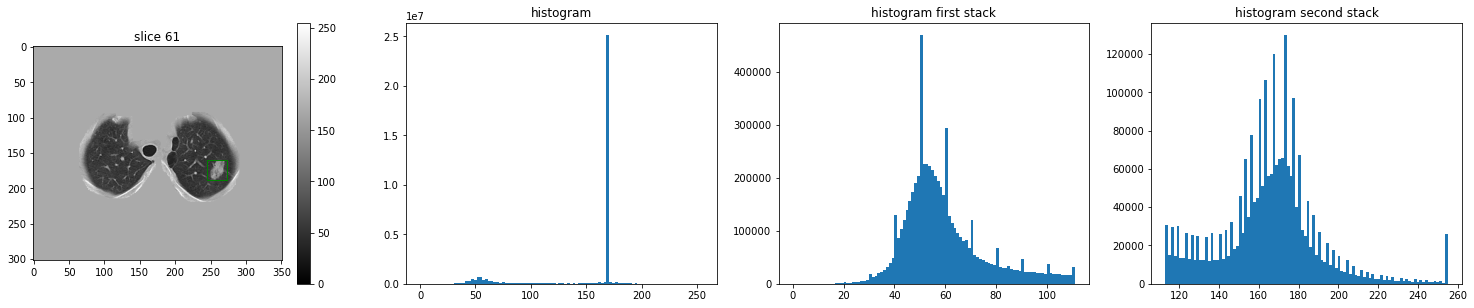

In [11]:
data_path = "./Methodist_incidental/data_Ben/masked/Lung_patient050/patient050-20130820_clean.npz"
label_path = None
nodule_index = 0
Slice = None
norm = "min_max"
print("Methodist masked data2 min_max norm")
plot_data(data_path, label_path, nodule_index, Slice, norm)

## Compare masked images (Mode norm)

Luna masked data mode norm
Load data:  ./LUNA16/masked_files/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260_clean.npy
Image shape:  (288, 212, 344)
Remove background 9.268055749774451


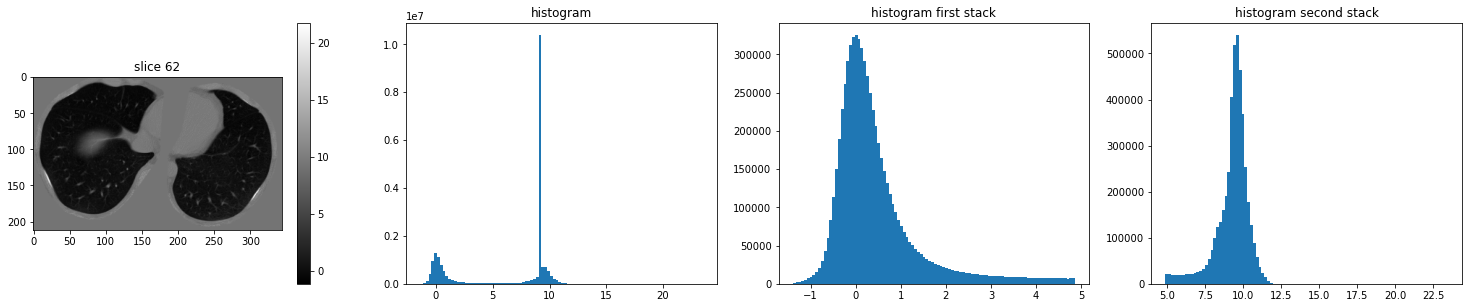

In [12]:
data_path = "./LUNA16/masked_files/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260_clean.npy"
label_path = None
nodule_index = 0
Slice = 62
norm = "mode_norm"
print("Luna masked data mode norm")
plot_data(data_path, label_path, nodule_index, Slice, norm)

Luna masked data mode norm
Load data:  ./LUNA16/masked_files/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492_clean.npy
Image shape:  (287, 191, 305)
All labels:  [[81.933381 166.26051683000003 43.932055500000004 6.440878725]]
Remove background 8.944083134719634


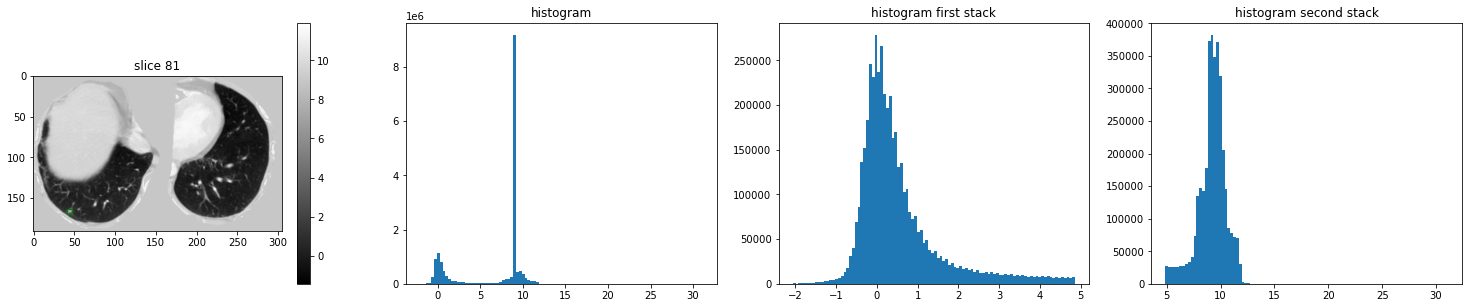

In [13]:
data_path = "./LUNA16/masked_files/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492_clean.npy"
label_path = None
nodule_index = 0
Slice = None
norm = "mode_norm"
print("Luna masked data mode norm")
plot_data(data_path, label_path, nodule_index, Slice, norm)

Methodist masked data mode norm
Load data:  ./Methodist_incidental/data_Ben/masked/Lung_patient002/patient002-20090310_clean.npz
Image shape:  (285, 255, 343)
All labels:  [[127.        189.        215.         24.0704501]]
Remove background 7.12471723160661


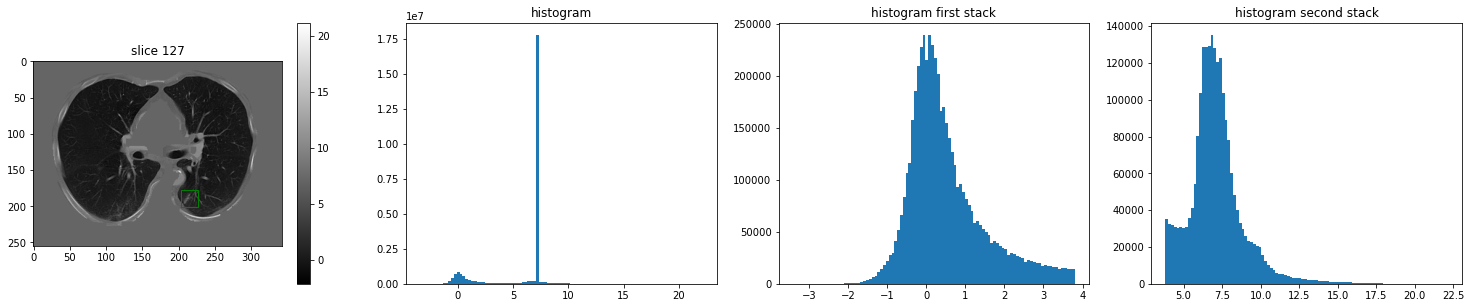

In [14]:
data_path = "./Methodist_incidental/data_Ben/masked/Lung_patient002/patient002-20090310_clean.npz"
label_path = None
nodule_index = 0
Slice = None
norm = "mode_norm"
print("Methodist masked data mode norm")
plot_data(data_path, label_path, nodule_index, Slice, norm)

Methodist masked data2 mode norm
Load data:  ./Methodist_incidental/data_Ben/masked/Lung_patient050/patient050-20130820_clean.npz
Image shape:  (315, 302, 351)
All labels:  [[ 61.         174.         259.          27.11545988]]
Remove background 7.186456579607435


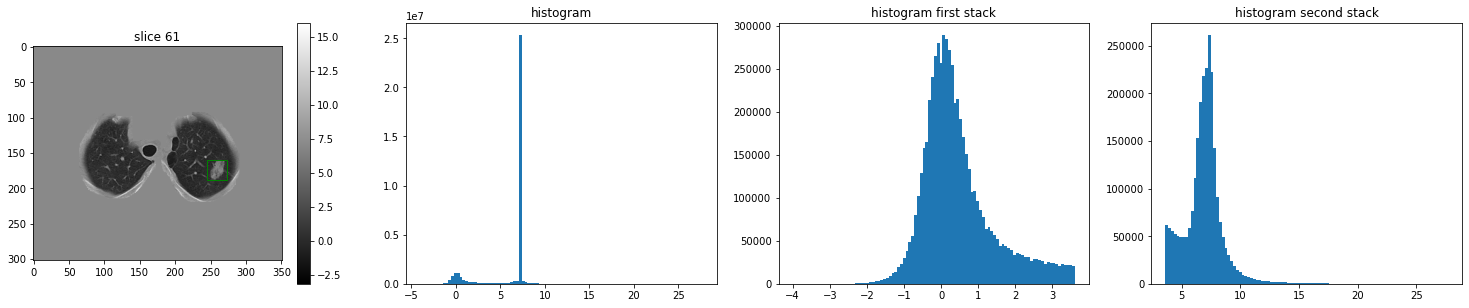

In [15]:
data_path = "./Methodist_incidental/data_Ben/masked/Lung_patient050/patient050-20130820_clean.npz"
label_path = None
nodule_index = 0
Slice = None
norm = "mode_norm"
print("Methodist masked data2 mode norm")
plot_data(data_path, label_path, nodule_index, Slice, norm)

## Temp

Luna masked data no norm
Load data:  ./LUNA16/masked_files/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492_clean.npy
Image shape:  (287, 191, 305)
Fisrt: Mode: -832.000000, std: 95.205950
Second: Mode: 1.000000, std: 120.249681
All labels:  [[81.933381 166.26051683000003 43.932055500000004 6.440878725]]
Remove background 0


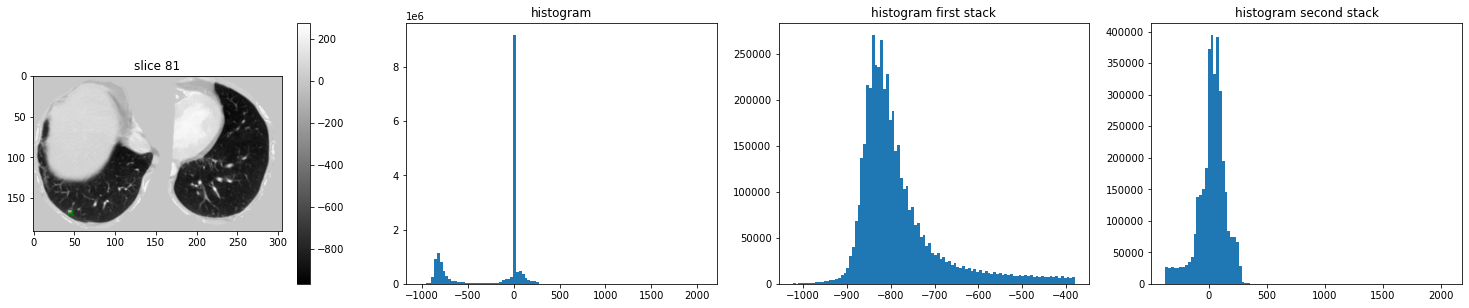

In [51]:
data_path = "./LUNA16/masked_files/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492_clean.npy"
label_path = None
nodule_index = 0
Slice = None
norm = None
print("Luna masked data no norm")
plot_data(data_path, label_path, nodule_index, Slice, norm)

Luna masked data mode norm
Load data:  ./LUNA16/masked_files/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260_clean.npy
Image shape:  (288, 212, 344)
Fisrt: Mode: -890.000000, std: 92.214609
Second: Mode: 1.000000, std: 108.449136
Remove background 0


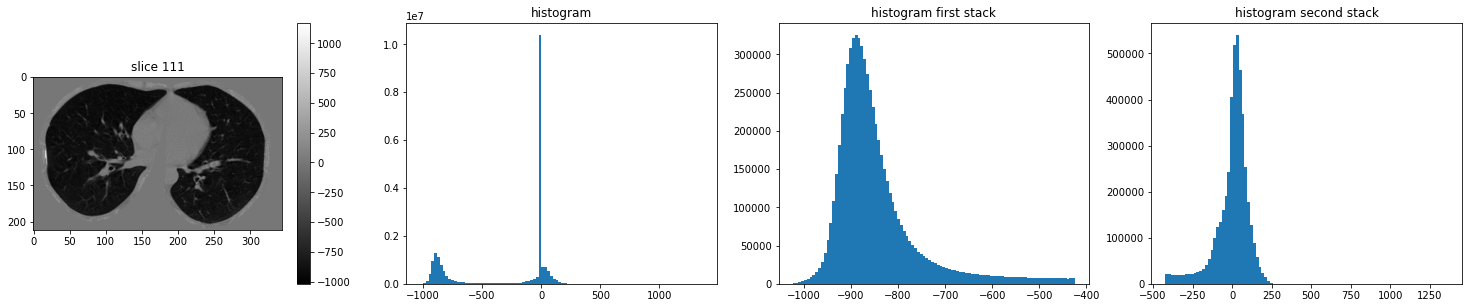

In [52]:
data_path = "./LUNA16/masked_files/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260_clean.npy"
label_path = None
nodule_index = 0
Slice = None
norm = None
print("Luna masked data mode norm")
plot_data(data_path, label_path, nodule_index, Slice, norm)

Luna masked data mode norm
Load data:  ./LUNA16/masked_files/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492_clean.npy
Image shape:  (287, 191, 305)
Mode: -832.000000, std: 93.022391
Fisrt: Mode: 0.000000, std: 1.017673
Second: Mode: 8.944083, std: 0.705220
All labels:  [[81.933381 166.26051683000003 43.932055500000004 6.440878725]]
Remove background 8.944083134719634


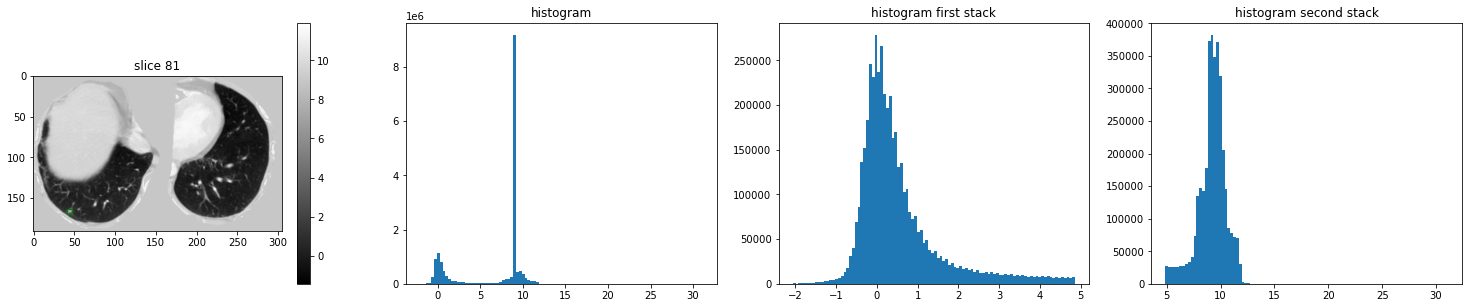

In [25]:
data_path = "./LUNA16/masked_files/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492_clean.npy"
label_path = None
nodule_index = 0
Slice = None
norm = "mode_norm"
print("Luna masked data mode norm")
plot_data(data_path, label_path, nodule_index, Slice, norm)

Methodist masked data2 no norm
Load data:  ./Methodist_incidental/data_Ben/masked/Lung_patient050/patient050-20130820_clean.npz
Image shape:  (315, 302, 351)
Fisrt: Mode: -832.000000, std: 118.247629
Second: Mode: 0.000000, std: 54.605664
All labels:  [[ 61.         174.         259.          27.11545988]]
Remove background 0


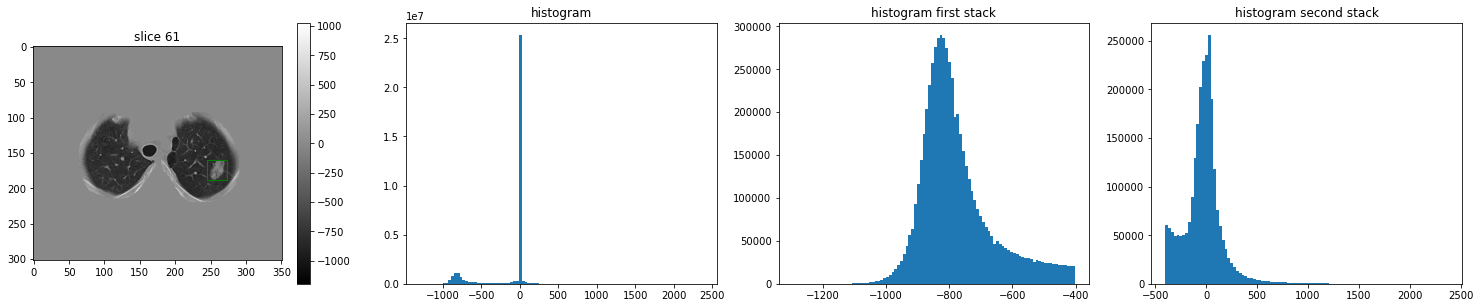

In [26]:
data_path = "./Methodist_incidental/data_Ben/masked/Lung_patient050/patient050-20130820_clean.npz"
label_path = None
nodule_index = 0
Slice = None
norm = None
print("Methodist masked data2 no norm")
plot_data(data_path, label_path, nodule_index, Slice, norm)

Methodist masked data2 mode norm
Load data:  ./Methodist_incidental/data_Ben/masked/Lung_patient002/patient002-20090310_clean.npz
Image shape:  (285, 255, 343)
Fisrt: Mode: -870.000000, std: 121.556050
Second: Mode: 0.000000, std: 71.842530
All labels:  [[127.        189.        215.         24.0704501]]
Remove background 0


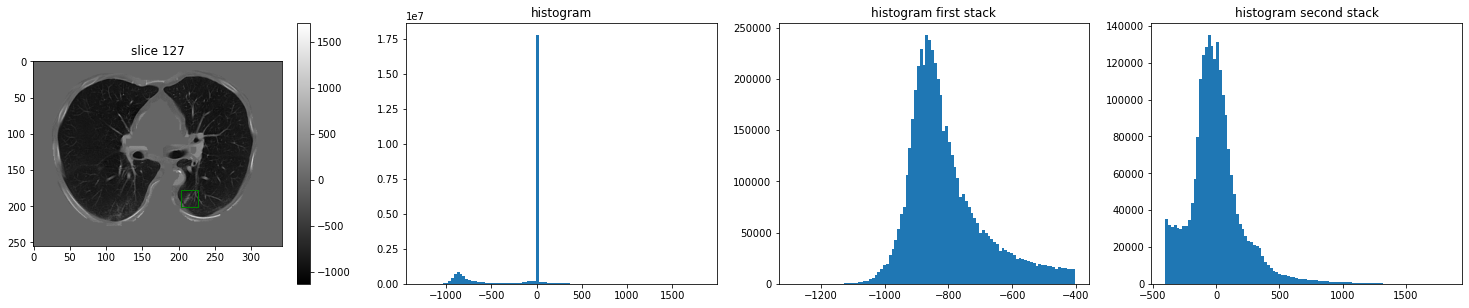

In [32]:
data_path = "./Methodist_incidental/data_Ben/masked/Lung_patient002/patient002-20090310_clean.npz"
label_path = None
nodule_index = 0
Slice = None
norm = None
print("Methodist masked data2 mode norm")
plot_data(data_path, label_path, nodule_index, Slice, norm)

In [ ]:
data_path = "./Methodist_incidental/data_Ben/masked/Lung_patient002/patient002-20090310_clean.npz"
label_path = None
nodule_index = 0
Slice = 0
norm = None
print("Methodist masked data no norm")
plot_data(data_path, label_path, nodule_index, Slice, norm)

Methodist masked PET data mode norm
Load data:  ./Methodist_incidental/data_Ben/masked/Lung_patient016/patient016-20121127_clean.npz
Image shape:  (865, 258, 393)
Mode: -872.000000, std: 119.151489
All labels:  [[274.         221.         193.          16.11252446]]
Remove background 7.318414643245404


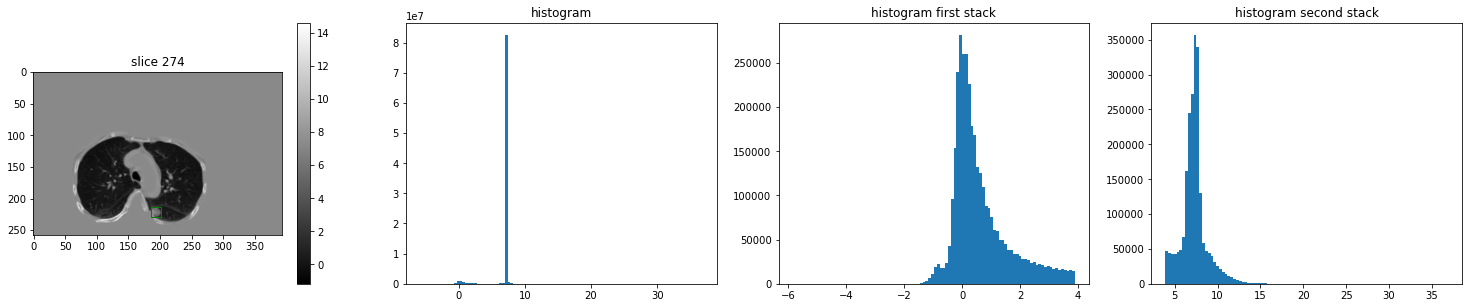

In [19]:
data_path = "./Methodist_incidental/data_Ben/masked/Lung_patient016/patient016-20121127_clean.npz"
label_path = None
nodule_index = 0
Slice = 500
norm = "mode_norm"
print("Methodist masked PET data mode norm")
plot_data(data_path, label_path, nodule_index, Slice, norm)

## Check statistic

In [64]:
root_dir = "./LUNA16/raw_files"
check_statistic(root_dir, label_path=None, norm=None)

./LUNA16/raw_files/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.277445975068759205899107114231.mhd
read itkimage successfully
Spaing is:  [1.79999995 0.7421875  0.7421875 ]
Remove background -1024
Fisrt: Mode: -1001.000000, std: 55.316552
Second: Mode: -109.000000, std: 75.370612
./LUNA16/raw_files/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd
read itkimage successfully
Spaing is:  [2.5        0.76171899 0.76171899]
Remove background -3024
Fisrt: Mode: -997.000000, std: 56.492477
Second: Mode: 46.000000, std: 79.970129
./LUNA16/raw_files/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd
read itkimage successfully
Spaing is:  [2.5        0.74218798 0.74218798]
Remove background -2048
Fisrt: Mode: -994.000000, std: 62.972072
Second: Mode: 56.000000, std: 85.251688
./LUNA16/raw_files/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd
read itkimage successfully
Spaing is:  [1.25       0.54882801 0.54882801]
Re

StatisticsError: no unique mode; found 2 equally common values

In [60]:
root_dir = "./Methodist_incidental/data_Ben/masked/"
check_statistic(root_dir, label_path=None, norm=None)

./Methodist_incidental/data_Ben/masked/Lung_patient002/patient002-20110314_clean.npz
Remove background 0
Fisrt: Mode: -879.000000, std: 76.938404
Second: Mode: -59.000000, std: 96.618320
./Methodist_incidental/data_Ben/masked/Lung_patient002/patient002-20090310_clean.npz
Remove background 0
Fisrt: Mode: -870.000000, std: 72.954504
Second: Mode: -83.000000, std: 93.898000
./Methodist_incidental/data_Ben/masked/Lung_patient002/patient002-20120906_clean.npz
Remove background 0
Fisrt: Mode: -881.000000, std: 74.050738
Second: Mode: -99.000000, std: 94.845564
./Methodist_incidental/data_Ben/masked/Lung_patient002/patient002-20100910_clean.npz
Remove background 0
Fisrt: Mode: -860.000000, std: 82.320555
Second: Mode: -59.000000, std: 97.468399
./Methodist_incidental/data_Ben/masked/Lung_patient005/patient005-20120524_clean.npz
Remove background 0
Fisrt: Mode: -847.000000, std: 72.767160
Second: Mode: -23.000000, std: 92.005482
./Methodist_incidental/data_Ben/masked/Lung_patient016/patient016

KeyboardInterrupt: 